# Attention Mechanisms — Definitions, Derivations, Computation & Visualizations

**Goals (what this notebook covers)**

1. Definition: what is attention and why we need it.
2. Derivation: scaled dot-product attention and the softmax normalization.
3. Step-by-step computation on a small toy sequence (with printed intermediate values).
4. Visualizations:
   - 2D attention heatmap (token × token attention).
   - 2D PCA of Query/Key/Value vectors.
   - 3D PCA trajectory of token embeddings through attention heads.
5. Short explanation of Multi-Head Attention and demonstration using a small multi-head module.
6. Use-cases & intuition.

All math uses `$...$` markup.


## Definition

Attention is a mechanism that lets a model dynamically focus on different parts of an input when producing each output. Informally, for a query vector $q$ we compute how much to attend to keys $k_j$ and then use those weights to form a weighted sum of values $v_j$.

---

## Scaled Dot-Product Attention (derivation)

Given a set of queries $Q=\{q_i\}_{i=1}^n$, keys $K=\{k_j\}_{j=1}^m$, and values $V=\{v_j\}_{j=1}^m$ (each vector in $\mathbb{R}^d$):

1. Compute raw compatibility scores (dot-products):
   $$ s_{ij} = q_i^\top k_j. $$

2. Scale scores by $\sqrt{d}$ to avoid large magnitudes:
   $$ \tilde s_{ij} = \frac{s_{ij}}{\sqrt{d}}. $$

3. Convert to probabilities with softmax along keys:
   $$ a_{ij} = \mathrm{softmax}_j(\tilde s_{ij}) = \frac{\exp(\tilde s_{ij})}{\sum_{j'} \exp(\tilde s_{ij'})}. $$

4. Weighted sum to produce attended outputs:
   $$ \text{attn}(q_i, K, V) = \sum_{j=1}^m a_{ij}\, v_j. $$

Matrix form:
$$
\text{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d}}\right) V.
$$

---

## Multi-head attention (intuition)

Split $d$ into $h$ heads, compute attention in each subspace (lower-$d$), then concatenate results. This lets the model attend to information at different representation subspaces.


In [1]:
# Python cell: imports & utilities
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# reproducibility
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:
# Python cell: scaled dot-product attention with step-by-step prints
def scaled_dot_product_attention(Q, K, V, mask=None, verbose=True):
    """
    Q: (n_q, d)
    K: (n_k, d)
    V: (n_k, d_v)
    returns: (n_q, d_v), attention_weights (n_q, n_k)
    """
    d = Q.shape[-1]
    # 1) raw scores: S = Q @ K^T
    S = Q @ K.T   # shape (n_q, n_k)
    if verbose:
        print("Raw scores S (Q @ K^T):\n", S)

    # 2) scale
    S_scaled = S / np.sqrt(d)
    if verbose:
        print("\nScaled scores S_scaled = S / sqrt(d):\n", S_scaled)

    # 3) optionally apply mask (mask should use -inf where masked)
    if mask is not None:
        S_scaled = S_scaled + mask
        if verbose:
            print("\nAfter mask applied (masked positions get -inf added):\n", S_scaled)

    # 4) softmax across keys (axis=1 corresponds to keys for each query row)
    A = np.exp(S_scaled - np.max(S_scaled, axis=1, keepdims=True))
    A = A / A.sum(axis=1, keepdims=True)
    if verbose:
        print("\nAttention weights A (softmax over keys):\n", A)
        print("\nRows sum to (should be 1):", A.sum(axis=1))

    # 5) output = A @ V
    out = A @ V
    if verbose:
        print("\nOutput (A @ V):\n", out)
    return out, A

# Tiny toy demonstration
d = 4
n_q = 3
n_k = 5
Q = np.array([[1.0, 0.0, 0.0, 0.0],
              [0.0, 1.0, 0.0, 0.0],
              [0.5, 0.5, 0.0, 0.0]])
K = np.random.randn(n_k, d) * 0.5
V = np.eye(d)[:n_k] if n_k <= d else np.random.randn(n_k, d)

print("Q:\n", Q)
print("K:\n", K)
print("V:\n", V)

out, A = scaled_dot_product_attention(Q, K, V, verbose=True)


Q:
 [[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]]
K:
 [[ 0.88202617  0.2000786   0.48936899  1.1204466 ]
 [ 0.933779   -0.48863894  0.47504421 -0.0756786 ]
 [-0.05160943  0.20529925  0.07202179  0.72713675]
 [ 0.38051886  0.06083751  0.22193162  0.16683716]
 [ 0.74703954 -0.10257913  0.15653385 -0.42704787]]
V:
 [[-2.55298982  0.6536186   0.8644362  -0.74216502]
 [ 2.26975462 -1.45436567  0.04575852 -0.18718385]
 [ 1.53277921  1.46935877  0.15494743  0.37816252]
 [-0.88778575 -1.98079647 -0.34791215  0.15634897]
 [ 1.23029068  1.20237985 -0.38732682 -0.30230275]]
Raw scores S (Q @ K^T):
 [[ 0.88202617  0.933779   -0.05160943  0.38051886  0.74703954]
 [ 0.2000786  -0.48863894  0.20529925  0.06083751 -0.10257913]
 [ 0.54105239  0.22257003  0.07684491  0.22067819  0.3222302 ]]

Scaled scores S_scaled = S / sqrt(d):
 [[ 0.44101309  0.4668895  -0.02580471  0.19025943  0.37351977]
 [ 0.1000393  -0.24431947  0.10264963  0.03041875 -0.05128957]
 [ 0.27052619  0.11128501  0.03842246

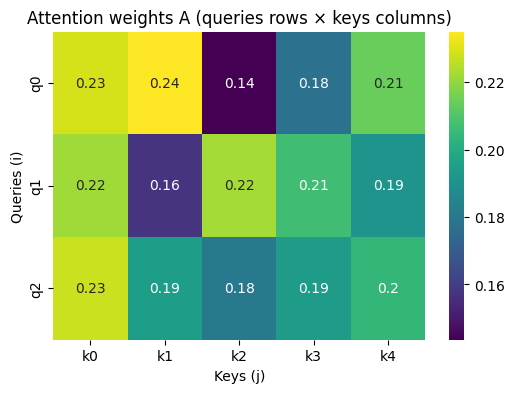

In [3]:
# Python cell: attention heatmap (token x token)
plt.figure(figsize=(6,4))
sns.heatmap(A, annot=True, cmap='viridis', xticklabels=[f'k{j}' for j in range(A.shape[1])],
            yticklabels=[f'q{i}' for i in range(A.shape[0])])
plt.title("Attention weights A (queries rows × keys columns)")
plt.xlabel("Keys (j)")
plt.ylabel("Queries (i)")
plt.show()


In the toy example above:
- We had 3 queries and 5 keys.
- We computed raw scores $S_{ij}=q_i^\top k_j$, scaled them by $\sqrt{d}$, applied softmax across keys to get attention weights $a_{ij}$.
- Finally we used the weights to compute outputs $\sum_j a_{ij} v_j$.
- The heatmap visualizes which key each query attends to the most.


In [4]:
# Python cell: small Multi-Head Attention module
class SmallMultiHeadAttention(nn.Module):
    def __init__(self, d_model=16, num_heads=4):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.w_out = nn.Linear(d_model, d_model, bias=False)

    def forward(self, X):  # X: (n, d_model)
        n = X.shape[0]
        Q = self.w_q(X)  # (n, d_model)
        K = self.w_k(X)
        V = self.w_v(X)

        # split heads => shape (h, n, d_k)
        Qh = Q.view(n, self.num_heads, self.d_k).permute(1,0,2)
        Kh = K.view(n, self.num_heads, self.d_k).permute(1,0,2)
        Vh = V.view(n, self.num_heads, self.d_k).permute(1,0,2)

        heads_out = []
        heads_A = []
        for h in range(self.num_heads):
            qh = Qh[h].detach().cpu().numpy()
            kh = Kh[h].detach().cpu().numpy()
            vh = Vh[h].detach().cpu().numpy()
            out_h, A_h = scaled_dot_product_attention(qh, kh, vh, verbose=False)  # no prints here
            heads_out.append(torch.tensor(out_h))
            heads_A.append(A_h)

        # concatenate heads outputs: each out_h is (n, d_k) -> stack along last dim
        heads_out_t = torch.cat([h_out for h_out in heads_out], dim=1).float()  # shape (n, d_model)
        final = self.w_out(heads_out_t.to(X.device))
        return final, heads_A

# Create toy input embeddings (e.g., 6 tokens)
n_tokens = 6
d_model = 16
toy_X = torch.randn(n_tokens, d_model, device=device)
mha = SmallMultiHeadAttention(d_model=d_model, num_heads=4).to(device)

out, heads_A = mha(toy_X)
print("Multi-head Attention output shape:", out.shape)
for idx, Ah in enumerate(heads_A):
    print(f"Head {idx} attention shape: {Ah.shape}")


Multi-head Attention output shape: torch.Size([6, 16])
Head 0 attention shape: (6, 6)
Head 1 attention shape: (6, 6)
Head 2 attention shape: (6, 6)
Head 3 attention shape: (6, 6)


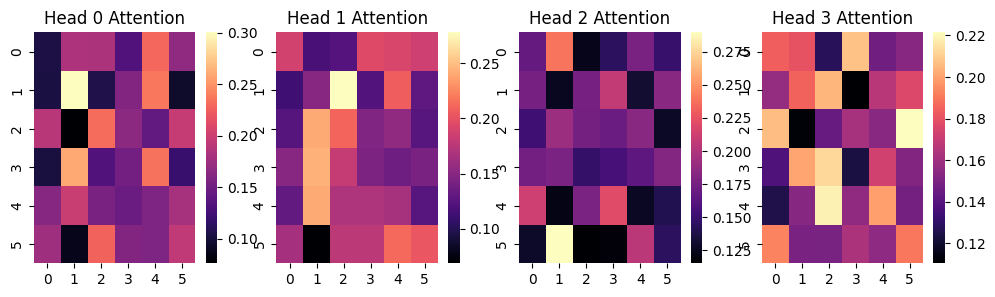

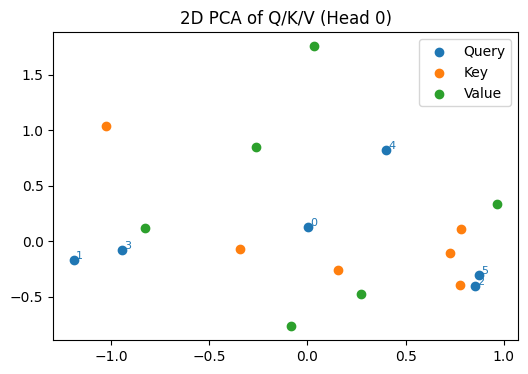

In [5]:
# Python cell: plot head attention heatmaps and PCA 2D of Query/Key/Value of head 0
num_heads = len(heads_A)
fig, axes = plt.subplots(1, num_heads, figsize=(3*num_heads,3))
for i in range(num_heads):
    sns.heatmap(heads_A[i], ax=axes[i], cmap='magma', annot=False)
    axes[i].set_title(f'Head {i} Attention')
plt.show()

# Extract Q/K/V for head 0
with torch.no_grad():
    Qfull = mha.w_q(toy_X).cpu().numpy()
    Kfull = mha.w_k(toy_X).cpu().numpy()
    Vfull = mha.w_v(toy_X).cpu().numpy()
d_k = d_model // 4
Q0 = Qfull[:, :d_k]
K0 = Kfull[:, :d_k]
V0 = Vfull[:, :d_k]

pca = PCA(n_components=2)
Q2 = pca.fit_transform(Q0)
K2 = pca.transform(K0)
V2 = pca.transform(V0)

plt.figure(figsize=(6,4))
plt.scatter(Q2[:,0], Q2[:,1], c='C0', label='Query')
plt.scatter(K2[:,0], K2[:,1], c='C1', label='Key')
plt.scatter(V2[:,0], V2[:,1], c='C2', label='Value')
for i in range(n_tokens):
    plt.text(Q2[i,0]+0.01, Q2[i,1]+0.01, f'{i}', color='C0', fontsize=8)
plt.legend(); plt.title('2D PCA of Q/K/V (Head 0)'); plt.show()


- Each head computes attention in a different learned subspace. The heatmaps show per-head attention weights (token × token).
- The 2D PCA plot shows where tokens lie in the head-0 subspace for Queries/Keys/Values. Close Q and K points produce higher dot-products.


In [6]:
# Python cell: toy sequence decoding using attention step-by-step (print explanation)
# We will simulate a "decoder step" where each token attends to previous tokens only (causal mask).

def causal_attention_demo(X, mha_module):
    """X: (n, d_model) input token embeddings.
       Show per-step attention when decoding left-to-right with causal masking."""
    n = X.shape[0]
    d = X.shape[1]
    print("Causal decoding demonstration (left-to-right).")
    outputs = []
    for t in range(n):
        # keys/values are all tokens up to t (inclusive) in real causal decoding, but queries are current token
        K = X[:t+1].cpu().numpy()
        V = X[:t+1].cpu().numpy()
        q = X[t].cpu().numpy().reshape(1,-1)
        out_t, A_t = scaled_dot_product_attention(q, K, V, verbose=True)
        print(f"\nStep t={t}: query token {t} attended to tokens 0..{t}")
        outputs.append(out_t)
        print("-"*60)
    return outputs

toy_X_cpu = toy_X.cpu()
_ = causal_attention_demo(toy_X_cpu, mha)


Causal decoding demonstration (left-to-right).
Raw scores S (Q @ K^T):
 [[21.288359]]

Scaled scores S_scaled = S / sqrt(d):
 [[5.32208967]]

Attention weights A (softmax over keys):
 [[1.]]

Rows sum to (should be 1): [1.]

Output (A @ V):
 [[-0.92466241 -0.42534423 -2.6438458   0.14518386 -0.1208664  -0.57972574
  -0.62285101 -0.3283869  -1.07454193 -0.36314395 -1.67105043  2.26550484
   0.31168479 -0.1841891   1.28664267  1.18195271]]

Step t=0: query token 0 attended to tokens 0..0
------------------------------------------------------------
Raw scores S (Q @ K^T):
 [[-2.434728 15.853059]]

Scaled scores S_scaled = S / sqrt(d):
 [[-0.60868198  3.9632647 ]]

Attention weights A (softmax over keys):
 [[0.01023204 0.98976796]]

Rows sum to (should be 1): [1.]

Output (A @ V):
 [[-0.13522045  1.20008752  1.39358184  1.05109542 -0.49031257 -1.41573847
  -0.72339503 -1.28735983  0.05798203 -0.01104649  1.86044032  0.70392159
  -0.07396133 -0.83059752  1.34999161 -0.27287994]]

Step t=1: 

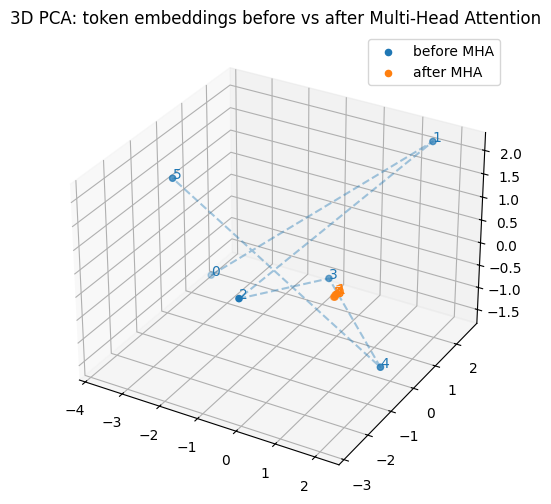

In [7]:
# Python cell: 3D PCA of tokens before and after one MHA layer
tokens = toy_X.cpu().numpy()  # (n_tokens, d_model)
after = out.detach().cpu().numpy()  # output of MHA (n_tokens, d_model)

pca3 = PCA(n_components=3)
all_vecs = np.vstack([tokens, after])
proj = pca3.fit_transform(all_vecs)
tokens3 = proj[:n_tokens]
after3 = proj[n_tokens:]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tokens3[:,0], tokens3[:,1], tokens3[:,2], c='C0', label='before MHA')
ax.plot(tokens3[:,0], tokens3[:,1], tokens3[:,2], linestyle='--', alpha=0.4)
ax.scatter(after3[:,0], after3[:,1], after3[:,2], c='C1', label='after MHA')
for i in range(n_tokens):
    ax.text(tokens3[i,0], tokens3[i,1], tokens3[i,2], str(i), color='C0')
    ax.text(after3[i,0], after3[i,1], after3[i,2], str(i), color='C1')
ax.set_title("3D PCA: token embeddings before vs after Multi-Head Attention")
ax.legend()
plt.show()


## Practical notes & common uses

- Attention is the core of Transformer models for language, vision, audio, and cross-modal tasks.
- Scaled dot-product attention is simple and efficient when implemented as matrix multiplications.
- Multi-head attention enables attending to different subspaces (syntactic vs semantic etc).
- Visualizing attention (heatmaps + PCA) provides intuition about what the model focuses on.


### Optional extensions I can provide (say which you want):
- A Pixel Transformer / full Auto-regressive PixelCNN-like attention model on MNIST with training + sampling.
- Full Transformer encoder/decoder toy training on a small character-level dataset and attention visualization.
- Cross-attention demo (text->image toy) showing how conditioning works.
- Hookable functions to save and visualize attention maps during real training of a Transformer.

Tell me which extension and I will append the code cells.
